In [1]:
import pandas as pd
import json,gc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
#Read only relevant category data

In [3]:
category_info = json.load(open('Data/categories.json'))

In [4]:
category_dict={int(d['id']):d['snippet']['title'] for d in category_info}

In [5]:
patterns = []
userid_mapping={}
with open('Data/complete_comments_with_vader.jsonl') as file:
    for line in file:
        line=json.loads(line)
        if not line['userId'] in userid_mapping:
            userid_mapping[line['userId']] = len(userid_mapping)
        patterns.append({'id':userid_mapping[line['userId']],'Item':int(line['category']),'Date':datetime.strptime(line['publishedAt'],"%Y-%m-%dT%H:%M:%SZ")})

In [6]:
#find percentage of overlaps
category_sets = {}
for pattern in patterns:
    if pattern['Item'] not in category_sets:
        category_sets[pattern['Item']]=set()
    category_sets[pattern['Item']].add(pattern['id'])

In [7]:
intersection_matrix = np.ones((len(category_sets),len(category_sets)))
for i,c1 in enumerate(category_sets):
    for j,c2 in enumerate(category_sets):
        if i == j:
            intersection_matrix[i,j] = np.nan
            continue
        intersection_matrix[i,j] = len(category_sets[c1].intersection(category_sets[c2]))/len(category_sets[c1].union(category_sets[c2]))

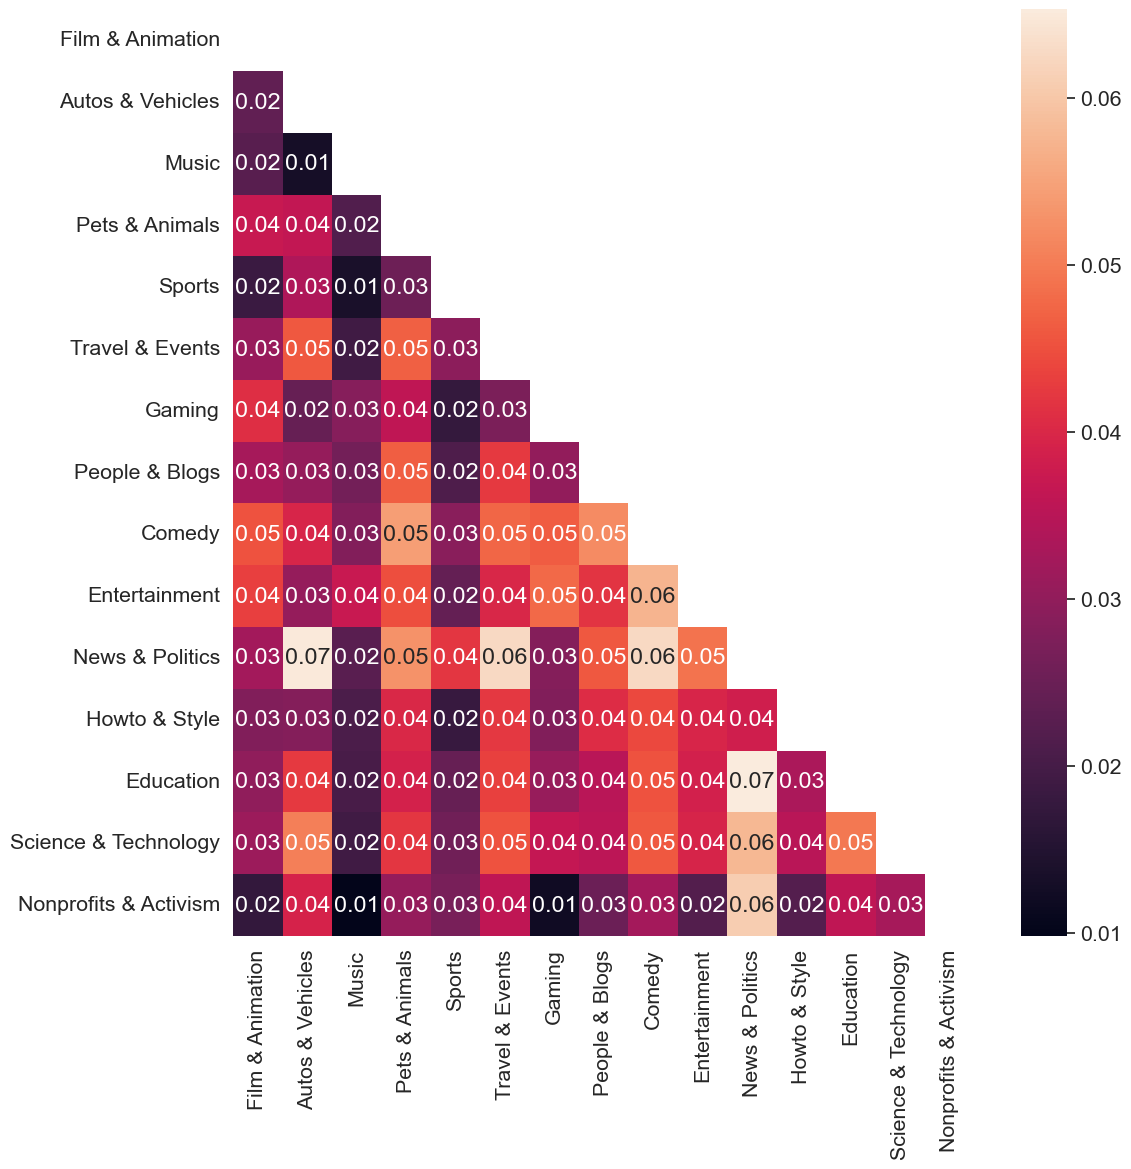

In [47]:
matrix = np.triu(intersection_matrix)
sns.set(rc={'figure.figsize':(12,12)})
sns.set(font_scale=1.4,style='white')
labels = [category_dict[i] for i in category_sets]
sns.heatmap(intersection_matrix,mask=matrix,annot=True,fmt='.2f',xticklabels=labels,yticklabels=labels)
plt.tight_layout()
plt.savefig('figures/community_overlap.pdf',format='pdf')
plt.show()

In [19]:
#generate transition matrix
def order(item):
    return (item['id'],item['Date'])
patterns = sorted(patterns, key=order) 

In [24]:
indexes = {cat:i for i,cat in enumerate(category_sets)}

In [25]:
count_matrix = np.zeros((len(category_sets),len(category_sets)))
last_user=None
last_topic=None
for pattern in patterns:
    if last_user == pattern['id']:
        transition_matrix[indexes[last_topic],indexes[pattern['Item']]]+=1
    last_user = pattern['id']
    last_topic = pattern['Item']

In [43]:
transition_matrix=(count_matrix/count_matrix.sum(axis=1,keepdims=1))

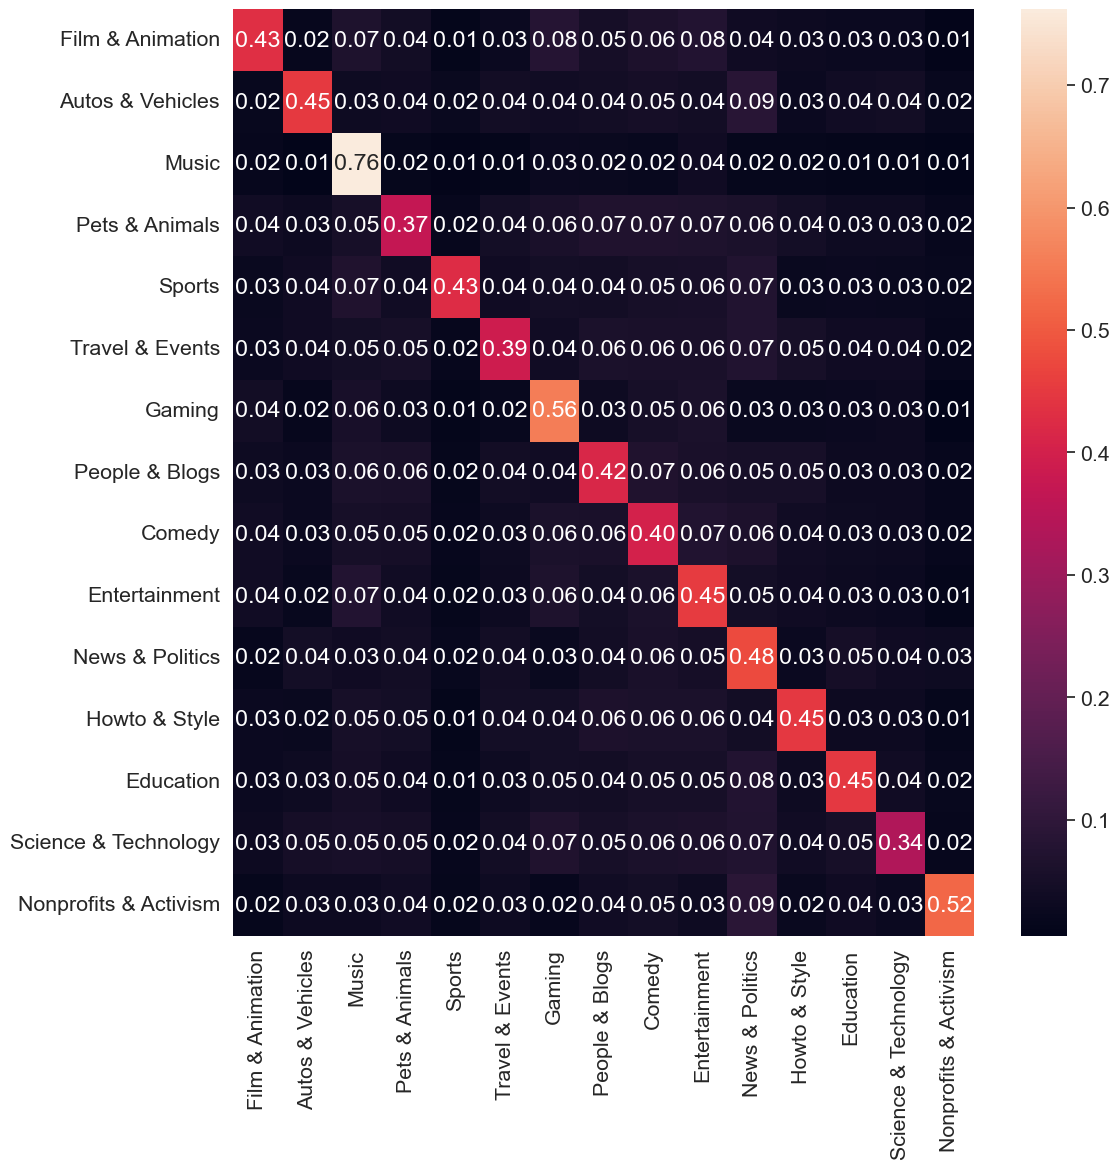

In [46]:
sns.set(rc={'figure.figsize':(12,12)})
sns.set(font_scale=1.4,style='white')
labels = [category_dict[i] for i in category_sets]
sns.heatmap(transition_matrix,annot=True,fmt='.2f',xticklabels=labels,yticklabels=labels)
plt.tight_layout()
plt.savefig('figures/transition_true.pdf',format='pdf')
plt.show()

In [76]:
#Get probability of topic change at n_th step
l = []
last_user=last_topic=None
steps_to_shift=0
for pattern in patterns:
    if last_user == pattern['id']:
        if pattern['Item'] != last_topic:
            l.append(steps_to_shift)
            steps_to_shift=0
        steps_to_shift+=1
    else:
        steps_to_shift=1
    last_user = pattern['id']
    last_topic = pattern['Item']

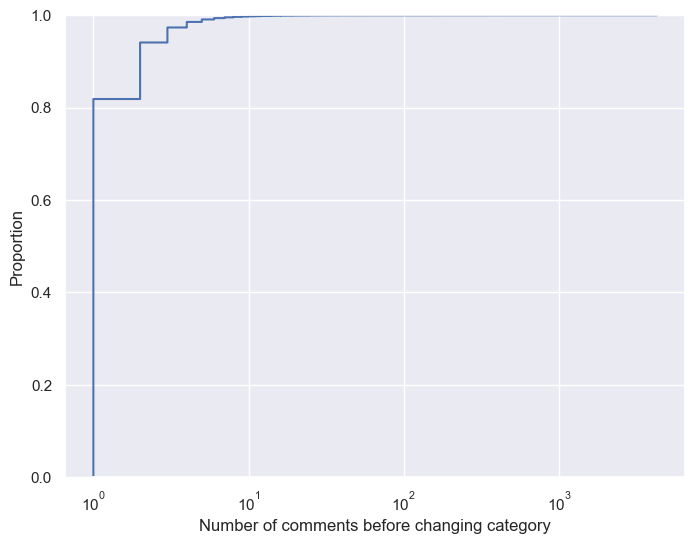

In [85]:
sns.set(rc={'figure.figsize':(8,6)})
sns.ecdfplot(l)
plt.xscale('log')
plt.xlabel('Number of comments before changing category')
plt.savefig('figures/ECDF_category_shifts.pdf',format='pdf')